# Weighted Portfolio

On the first trading day of every month, rebalance portfolio to given percentages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbols = ['SPY', 'TLT', 'GLD']
weights = {'SPY': 0.50, 'TLT': 0.40, 'GLD': 0.10}
directions = {'SPY': pf.Direction.LONG, 'TLT': pf.Direction.LONG, 'GLD': pf.Direction.LONG}
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

use_cache = False

In [4]:
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, use_cache=use_cache)

In [5]:
# add calendar columns
ts = portfolio.calendar(ts)

In [6]:
ts, start = portfolio.finalize_timeseries(ts, start)

In [7]:
portfolio.init_trade_logs(ts, capital)

In [8]:
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # rebalance on the first trading day of each month
    if row.first_dotm or end_flag:
        #portfolio.print_holdings(date, row)
        for symbol in portfolio.symbols:
            price = getattr(row, symbol + '_close')
            weight = 0 if end_flag else weights[symbol]
            direction = directions[symbol]
            portfolio.adjust_percent(date, price, weight, symbol, row, direction)
    # record daily balance
    portfolio.record_daily_balance(date, row)

In [9]:
rlog, tlog, dbal = portfolio.get_logs()

In [10]:
rlog.head()

,date,price,shares,entry_exit,direction,symbol
0,2004-12-01,86.95,57,entry,LONG,SPY
1,2004-12-01,51.53,77,entry,LONG,TLT
2,2004-12-01,45.38,22,entry,LONG,GLD
3,2005-01-03,43.02,1,entry,LONG,GLD
4,2005-01-03,53.09,1,exit,LONG,None


In [11]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
233,2013-05-01,141.11,2017-02-01,115.20,-25.91,-25.91,1,18244.18,LONG,GLD
234,2013-05-01,141.11,2017-08-01,120.65,-20.46,-20.46,1,18223.72,LONG,GLD
235,2013-05-01,137.10,2020-06-22,310.67,173.57,173.57,1,18397.29,LONG,SPY
236,2013-06-03,95.92,2020-03-02,153.32,57.41,287.03,5,18684.32,LONG,TLT
237,2013-07-01,121.13,2017-09-01,126.06,4.93,4.93,1,18689.25,LONG,GLD
...,...,...,...,...,...,...,...,...,...,...
328,2020-03-02,305.94,2020-06-22,310.67,4.73,9.47,2,27312.65,LONG,SPY
329,2020-04-01,245.07,2020-06-22,310.67,65.60,196.80,3,27509.45,LONG,SPY
330,2020-05-01,281.55,2020-06-22,310.67,29.12,145.59,5,27655.04,LONG,SPY
331,2020-05-01,167.73,2020-06-22,162.41,-5.32,-31.95,6,27623.10,LONG,TLT


In [12]:
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2020-06-16,37388.90,37388.90,37388.90,174,261.59,-
2020-06-17,37376.83,37376.83,37376.83,174,261.59,-
2020-06-18,37531.78,37531.78,37531.78,174,261.59,-
2020-06-19,37474.78,37474.78,37474.78,174,261.59,-
2020-06-22,37623.75,37623.75,37623.75,0,37623.75,X


In [13]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  2004-11-18
end                                                    2020-06-22
beginning_balance                                           10000
ending_balance                                           37623.75
total_net_profit                                         27623.75
gross_profit                                             28070.31
gross_loss                                                -446.56
profit_factor                                               62.86
return_on_initial_capital                                  276.24
annual_return_rate                                           8.87
trading_period                           15 years 7 months 4 days
pct_time_in_market                                          99.80
total_num_trades                                              333
trades_per_year                                             21.35
num_winning_trades                                            314
num_losing

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

2004-11-18 00:00:00 BUY  115 SPY @ 86.59
2020-06-22 00:00:00 SELL 115 SPY @ 310.67


In [15]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

In [16]:
benchmark.stats = benchmark.get_stats()

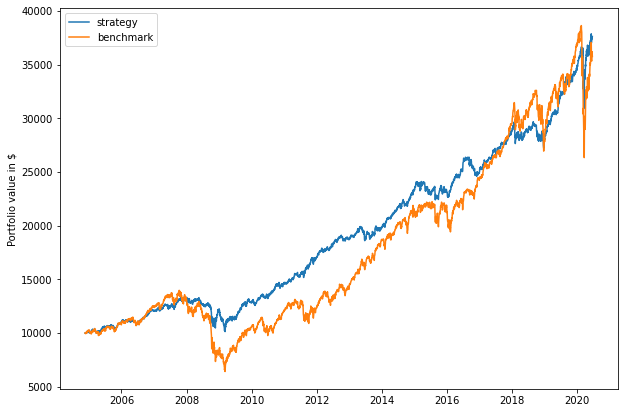

In [17]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

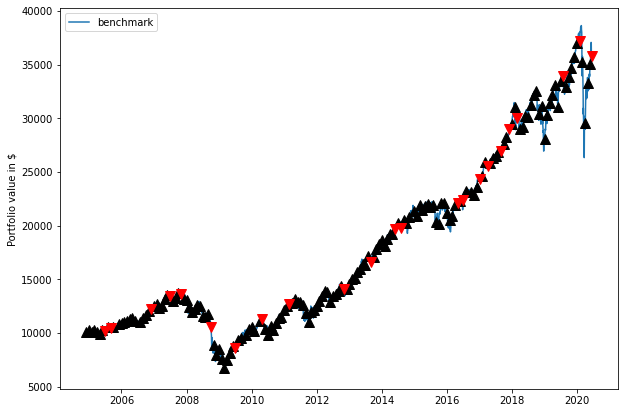

In [18]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

In [19]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$37,623.75","$35,768.79"
total_net_profit,"$27,623.75","$25,768.79"
gross_profit,"$28,070.31","$25,768.79"
gross_loss,-$446.56,$0.00


,strategy,benchmark
annual_return_rate,8.87,8.52
max_closed_out_drawdown,-24.08,-54.09
drawdown_annualized_return,-2.71,-6.35
drawdown_recovery,-1.26,-1.41
best_month,16.84,21.12
worst_month,-15.59,-30.70
sharpe_ratio,1.01,0.63
sortino_ratio,1.31,0.76
monthly_std,2.36,4.26


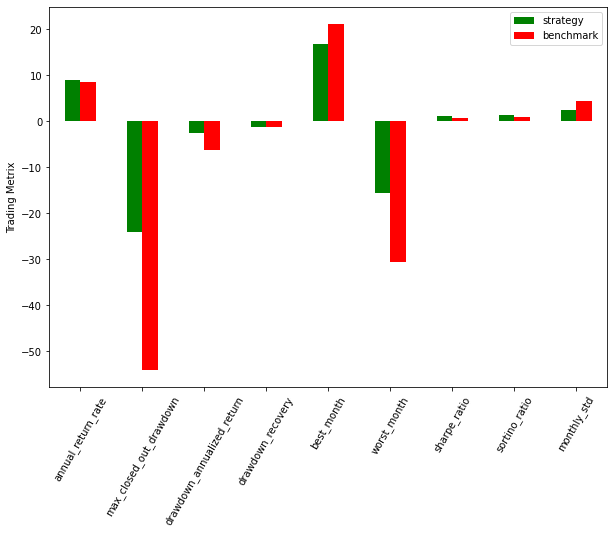

In [20]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df